# Example analysis pipeline

## Simple comparison of neural activity during stimulus condition on/off 


Load in relevant local application modules:

In [1]:
import sys
import matplotlib.pyplot as plt

import os
import sys
import numpy as np
import random
from random import uniform
import copy

from types import SimpleNamespace
import inflect

# Local application imports 
from database.db_setup import *
import preprocessing.data_preprocessing.binning as binning
import preprocessing.data_preprocessing.create_vectors_from_time_points as create
import annotation.stimulus_driven_annotation.movies.annotation_utils as utils

Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306


Set parameters:

In [2]:
patient_id = 1
session_nr = 1
unit_nr = 40
bin_size = 1000

Get activity from the database, set binning parameters, and bin: 

In [3]:
spike_times = get_spiking_activity(patient_id, session_nr, unit_nr)
spike_times = np.sort(spike_times) / 1000

exclude_pauses = False
output_edges = True

binned_spikes, edges = binning.bin_spikes(patient_id, session_nr, spike_times, bin_size, exclude_pauses, output_edges) 

In [4]:
edges

array([449860.09750073, 451063.27432558, 452266.45115043, 453469.62797527,
       454672.80480012, 455875.98162497, 457079.15844981, 458282.33527466])

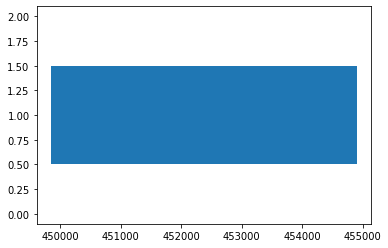

In [5]:
plt.eventplot(spike_times)

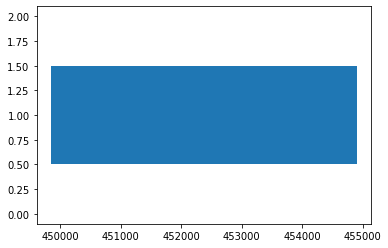

In [6]:
plt.eventplot(spike_times)

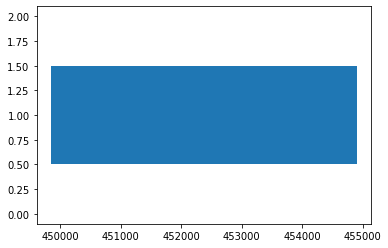

In [7]:
plt.eventplot(spike_times)

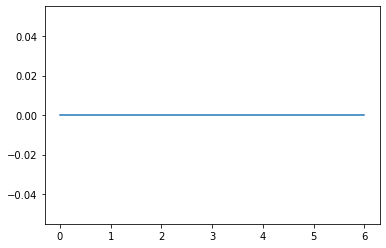

In [15]:
plt.plot(binned_spikes)

In [37]:
(354900349 - 349860058) / 1000 

5040.291

In [36]:
(rectime[-1] - rectime[0]) / 84 

1779.8480225554556

In [29]:
rectime = get_neural_rectime_of_patient(patient_id, session_nr) / 1000

In [12]:
test = np.load("/home/hitchhiker/Documents/DeepHumanVision_deploy/mock_data/patient_data/1/session_1/event_file/Events.npy")

In [16]:
print(test[0][0])
print(test[-1][0])

449860058.0
454889058.0


In [68]:
def generate_pings():
    """
    Recreate how Neurolynx interfaces with a local computer. 
    """
    len_context_files = random.randint(4000, 5400) # generate length of events.nev & DAQ file. 

    # recreate pings
    if len_context_files % 8 == 0:
        reps = int(len_context_files / 8)
    else:
        reps = int(len_context_files / 8) + 1

    signal_tile = np.tile([1,2,4,8,16,32,64,128], reps)
    signal_tile = signal_tile[:len_context_files]
    
    return len_context_files, signal_tile

def generate_events(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time):
    """
    Generate mock Events.nev file. Save as Events.npy file. 
    """
    
    # recreate event timestamps
    events = np.linspace(begin_recording_time, stop_recording_time, num=len_context_files)

    events_mat = np.array(list(zip(events, signal_tile)))
    
    return events_mat

def generate_daq_log(patient_id, session_nr, len_context_files, signal_tile, seed=1590528227608515, stimulus_len=83.816666):
    """
    Generate mock DAQ log. 
    
    Must use same values for signal_tile and len_context_files as the events.nev mock-up
    
    params:
    stimulus_len: length of the stimulus presentation, in minutes
    
    """
    #uses same values for signal_tile and len_context_files as the events.nev mock-up
    values = signal_tile
    index = np.arange(len_context_files)
    
    # generate projected end time for the DAQ log, in unix time microseconds
    movie_len_unix = (stimulus_len * 60 * 1000 * 1000)
    end_time = seed + movie_len_unix 
    add_interval = int((end_time - seed) / len_context_files)
    
    print(movie_len_unix)
    print(end_time)
    print(add_interval)
    
    pre = []
    post = []

    for i in range(len_context_files):
        interval_diff = (np.random.normal(1000, 200) / 2)

        pre.append(int(seed - interval_diff))
        post.append(int(seed + interval_diff))
        #seed += np.random.normal(1000144, 100)
        seed += add_interval 
        
    log_lines = list(zip(values, index, pre, post))
    
    return log_lines
    
def generate_playback_artifacts(patient_id, session_nr, seed=1590528227608515, stimulus_len=83.816666):
    """
    Generate a movie watchlog file with pauses and skips.
    """
    
    nr_movie_frames = 125725      # movie length: 5029 seconds (AVI file); 5029/0.04 = 125725
    perfect_pts = [round((x * 0.04), 2) for x in range(1, nr_movie_frames+1)]  

    # generate projected end time for the DAQ log, in unix time microseconds
    movie_len_unix = (stimulus_len * 60 * 1000 * 1000)
    end_time = seed + movie_len_unix 
    add_interval = int((end_time - seed) / nr_movie_frames)
    
    print(movie_len_unix)
    print(end_time)
    print(add_interval)
    
    cpu_time = []
    
    for i in range(nr_movie_frames):
        seed += add_interval
        cpu_time.append(seed)    
        
    ## add in pauses
    nr_pauses = int(uniform(1,6))

    # randomly select indices from perfect watchlog 
    indices_pause = random.sample(range(len(cpu_time) - 5000), nr_pauses)
    
    cpu_time = np.array(cpu_time)
    
    for i, index in enumerate(indices_pause): 
        pause_len = int(uniform(100000000, 3000000000)) ## TODO: this might be causing too big a difference btw wl and daq
        cpu_time = np.concatenate((cpu_time[:index],cpu_time[index:] + pause_len)) 
        
    nr_skips = int(uniform(1,4))

    # randomly select indices from perfect watchlog 
    indices_skip = random.sample(range(len(perfect_pts) - 5000), nr_skips)

    skip_pts = np.array(copy.copy(perfect_pts))
    
    max_skip = 500

    for i, index in enumerate(indices_skip): 
        # note: careful about values here -- can exceed mocked movie length. 
        # currently set so that the max possible skip is the penultimate frame
        if len(indices_skip) > 1:
            skip_len = int(uniform((max_skip * -1), max_skip))
            skip_pts = np.concatenate((skip_pts[:index],skip_pts[index:] + skip_len)) 
            max_skip -= skip_len

        if len(indices_skip) == 1:
            skip_len = max_skip
            skip_pts = np.concatenate((skip_pts[:index],skip_pts[index:] + skip_len)) 

    # test for rounding issue
    skip_pts = [round(frame, 2) for frame in skip_pts]

    # prevents generated frame from exceeding the mock movie length
    skip_pts_revised = []
    for i, frame in enumerate(skip_pts):
        if frame > (nr_movie_frames * 0.04):
            skip_pts_revised.append(nr_movie_frames * 0.04)
        if frame <= (nr_movie_frames * 0.04):
            skip_pts_revised.append(frame)
        if frame < 0: 
            skip_pts_revised.append(0.0)
    return skip_pts_revised, cpu_time

In [70]:
patient_id = 1
session_nr = 1
begin_recording_time = 449860058
stop_recording_time =  454889058

len_context_files, signal_tile = generate_pings()
events_mat = generate_events(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time)
daq = generate_daq_log(patient_id, session_nr, len_context_files, signal_tile, seed=1590528227608515, stimulus_len=83.816666)
wl = generate_playback_artifacts(patient_id, session_nr, seed=1590528227608515, stimulus_len=83.816666)

5028999960.0
1590533256608475.0
1218265
5028999960.0
1590533256608475.0
39999


In [41]:
events_mat

array([[4.49860058e+08, 1.00000000e+00],
       [4.49861069e+08, 2.00000000e+00],
       [4.49862081e+08, 4.00000000e+00],
       ...,
       [4.54887035e+08, 4.00000000e+00],
       [4.54888047e+08, 8.00000000e+00],
       [4.54889058e+08, 1.60000000e+01]])

In [73]:
(454889058 - 449860058) / 1000 / 60

83.81666666666666

In [54]:
(wl[1][-1] - wl[1][0]) 

5720943835

In [64]:
(daq[-1][3] - daq[0][3])# / 1000 / 1000 / 60

5027771961

In [65]:
print(daq[0][3])
print(wl[1][0])

1590528227608920
1590528227648514


In [66]:
print(daq[-1][3])
print(wl[1][-1])

1590533255380881
1590533948592349


In [13]:
erd = dj.ERD(dhv_schema)
erd

In [12]:
LabelProcessingMethod.drop()

`db_deploy_mock`.`#label_processing_method` (2 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


In [18]:
rec = get_neural_rectime_of_patient(patient_id, session_nr)

In [20]:
rec * 1000

array([4.49860098e+11, 4.49860138e+11, 4.49860178e+11, ...,
       4.58282255e+11, 4.58282295e+11, 4.58282335e+11])

In [62]:
get_info_continuous_watch_segments(patient_id, session_nr)

(array([0, 1, 2, 3]),
 array([4.49861247e+08, 4.73750484e+08, 5.52512790e+08, 5.61540968e+08]),
 array([4.73749294e+08, 5.52511600e+08, 5.61539779e+08, 5.99368481e+08]))

In [63]:
get_start_stop_times_pauses(patient_id, session_nr)

(array([506049.53045211, 542000.52297208, 550610.11469553, 564309.35611276,
        587416.12386267]),
 array([506051.9133717 , 542002.90211572, 550612.49586211, 564311.73961107,
        587418.51156834]))

In [12]:
Patient.drop()

`db_deploy_mock`.`#patient` (3 tuples)
`db_deploy_mock`.`_electrode_unit` (268 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


In [60]:
dts = get_dts_of_patient(patient_id, session_nr)
dts = dts /  1000

Note: Divide the patient dts vector by 1000 to get milliseconds


In [11]:
dts[0]

1590863712370.507

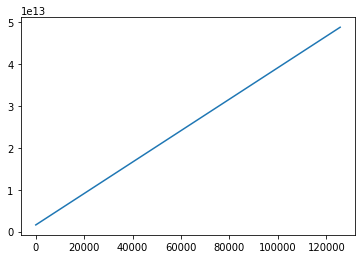

In [61]:
plt.plot(dts)

Using edges outputted above, generate a vector representing when a feature was presented during the stimulus:  

In [13]:
PatientAlignedMovieAnnotation()

annotator_id unique ID for each annotator,label_name label name,annotation_date date of annotation,session_nr session ID,patient_id patient ID,label_in_patient_time label matched to patient time (pts),values list of values that represent label,start_times list of start times of label segments in neural recording time,stop_times list of stop times of label segments in neural recording time,additionl_information
p1,character1,2019-12-12,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character1,2019-12-12,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,character1,2019-12-12,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p1,location1,2020-01-01,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,


In [14]:
label_name = "character1"
annotator_id = "p1"
annotation_date = "2019-12-12	"

values, starts, stops = get_patient_aligned_annotations(patient_id, label_name, annotator_id, annotation_date)

In [7]:
starts

array([449860.09750073])

In [8]:
stops

array([458282.33527466])

In [9]:
values

array([0])

In [10]:
character1_binned = create.create_vector_from_start_stop_times_reference(edges, values, starts, stops)

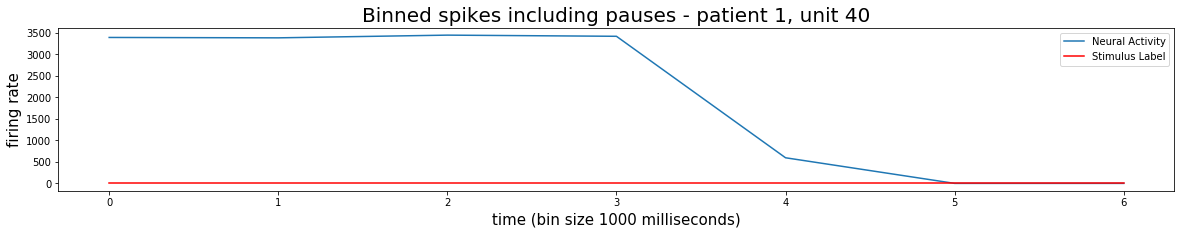

In [11]:
fig = plt.figure(figsize=(20,3))
plt.plot(binned_spikes, label="Neural Activity")
plt.plot(character1_binned, color="r", label="Stimulus Label")
if exclude_pauses:
    plt.title("Binned spikes excluding pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
else:
    plt.title("Binned spikes including pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
plt.xlabel("time (bin size {} milliseconds)".format(bin_size), fontsize=15)
plt.ylabel("firing rate", fontsize=15)

plt.legend()

plt.show()

Split activity into groups corresponding to the stimulus values, 

* One: Stimulus-on condition 
* Zero: Stimulus-off condition

In [65]:
tom_splits = utils.split_activity_by_value(binned_spikes, tom_binned)
tom_activity = SimpleNamespace(**tom_splits)

In [66]:
print(tom_activity.zero)
print(tom_activity.one)

print(len(tom_activity.zero) + len(tom_activity.one))
print(len(tom_binned))

[0 1 1 ... 0 0 0]
[4 1 2 ... 0 1 0]
4804
4804


In [69]:
## TODO, add in perm testing module to use here 
## TODO: mock movie labels (original labels,  and then mock patient aligned labels. check that the watchlog can be sufficiently busted up )



In [9]:
# reload and test
get_brain_region(patient_id, 10)
get_dts_of_patient(patient_id, session_nr)
get_number_of_units_for_patient(patient_id)

Note: Divide the patient dts vector by 1000 to get milliseconds


'dts.npy'

In [15]:
get_original_movie_label(label_name, annotation_date, annotator_id)

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [17]:
get_patient_level_cleaning_vec_from_db(patient_id, session_nr, name_of_vec, annotator_id)

NameError: name 'name_of_vec' is not defined

In [18]:
get_patient_level_data_cleaning(patient_id, session_nr, vector_name)

NameError: name 'vector_name' is not defined

In [21]:
get_spikes_from_brain_region(patient_id, session_nr, "LAH")

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [22]:
get_start_stop_times_pauses(patient_id, session_nr)

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [23]:
get_unit_id(csc_nr, unit_type, unit_nr, patient_id)

NameError: name 'csc_nr' is not defined

In [24]:
get_unit_ids_in_brain_region(patient_id, "LAH")

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [ ]:
get_unit_level_data_cleaning(patient_id, session_nr, unit_id, name)